# The Beginning

we need the following packages:

* `numpy`: to manipulate in vector array
* `vaex`: to open and manipulate big data in dataframe
* `astroquery.gaia.Gaia`: to query Gaia DR3
* `astroquery.utils.tap.core.Tap`: to query 2MASS from Tap protocols

and some utility packages:

* `datetime`: to get the current time
* `time`: to get the current time
* `os.path`:
    * `join`: to join path
    * `abspath`: to get the absolute path

* `os`:
    * `mkdir`: to create a directory
    * `rmdir`: to remove a directory
    * `pardir`: to get the parent directory
* `sys`: to import local package
* `glob`: to get the list of files in a directory



In [1]:
import numpy as np
import vaex
from astroquery.gaia import Gaia
from astroquery.utils.tap.core import Tap

from datetime import datetime
from time import time
from os.path import join, abspath
from os import pardir
from glob import glob
import sys

import some utility packages

* timeout: to set the timeout for the query
* append_name: append table name to the column name

In [2]:
# import utils
util_dir = join(abspath(pardir))
if not util_dir in sys.path:
    sys.path.insert(0, util_dir)
sys.path

['/home2/s20321005/Thesis-Project',
 '/home2/s20321005/Thesis-Project/1_Collecting_Data',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages']

In [3]:
from utils import (launch_job, append_name, progressbar, safe_mkdir, print_or_write, 
                    write_to, delete_directory, iterate_job)

In [4]:
# get the root of data directory
root_data_dir = abspath(join(pardir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [5]:
# Create a directory for Gaia DR3 and 2MASS data
# or if it already exists, just move on
name = "Gaia-2MASS-5"
gaia_data_dir = join(root_data_dir, name)
safe_mkdir(gaia_data_dir)

Directory /home2/s20321005/Thesis-Project/Data/Gaia-2MASS-5 already exist. Good to go!


In [6]:
# Do the same for 2MASS data
name = "TWOMASS-5"
tmass_data_dir = join(root_data_dir, name)
safe_mkdir(tmass_data_dir)

Directory /home2/s20321005/Thesis-Project/Data/TWOMASS-5 already exist. Good to go!


### defining columns

there are many columns and tables in Gaia DR3 that we need.

gaiadr3.gaia_source AS gdr3:
| Name | Description | Unit |
| --- | --- | --- |
| pm | proper motion | mas/yr |
| pmra | proper motion in right ascension (already corrected for declination) | mas/yr |
| pmdec | proper motion in declination | mas/yr |
| pmra_error (e_pmra) | error of proper motion in right ascension | mas/yr |
| pmdec_error (e_pmdec) | error of proper motion in declination | mas/yr |
| parallax | parallax | mas |
| parallax_error (e_parallax) | error of parallax | mas |
| phot_g_mean_mag (gmag) | mean magnitude in G band | mag |
| phot_bp_mean_mag (bpmag) | mean magnitude in BP band | mag |
| phot_rp_mean_mag (rpmag) | mean magnitude in RP band | mag |
| phot_bp_mean_flux_over_error (fb_over_err) | mean flux in BP band over error | - |
| phot_rp_mean_flux_over_error (fr_over_err) | mean flux in RP band over error | - |
| ruwe | robust estimator of the weighted scatter of the astrometric solution | - |
| phot_bp_rp_excess_factor (excess_factor) | excess factor of the BP-RP color | - |
| radial_velocity (rv_gaia) | radial velocity | km/s |
| radial_velocity_error (e_rv_gaia) | error of radial velocity | km/s |
| l (glon) | galactic longitude | deg |
| b (glat) | galactic latitude | deg |
| teff_gspphot | effective temperature according to gssphot | K |
| teff_gspphot_upper | upper error of effective temperature according to gssphot | K |
| teff_gspphot_lower | lower error of effective temperature according to gssphot | K |
| logg_gspphot | surface gravity according to gssphot | dex |
| logg_gspphot_upper | upper error of surface gravity according to gssphot | dex |
| logg_gspphot_lower | lower error of surface gravity according to gssphot | dex |

gaiadr3.astrophysical_parameters AS astrophysical:
| Name                    | Description                                                     | Unit  |
|-------------------------|-----------------------------------------------------------------|-------|
| `mh_gspphot`            | metallicity according to gssphot                                 | dex   |
| `mh_gspphot_upper`      | upper error of metallicity according to gssphot                  | dex   |
| `mh_gspphot_lower`      | lower error of metallicity according to gssphot                  | dex   |
| `distance_gspphot`      | distance according to gssphot                                    | pc    |
| `distance_gspphot_upper`| upper error of distance according to gssphot                     | pc    |
| `distance_gspphot_lower`| lower error of distance according to gssphot                     | pc    |
| `ag`                    | extinction in G band                                            | mag   |
| `ag_upper`              | upper error of extinction in G band                              | mag   |
| `ag_lower`              | lower error of extinction in G band                              | mag   |
| `mh_gspspec`            | metallicity according to gspspec                                  | dex   |
| `mh_gspspec_upper`      | upper error of metallicity according to gspspec                   | dex   |
| `mh_gspspec_lower`      | lower error of metallicity according to gspspec                   | dex   |
| `alphafe_gspspec`       | alpha abundance according to gspspec                              | dex   |
| `alphafe_gspspec_upper` | upper error of alpha abundance according to gspspec               | dex   |
| `alphafe_gspspec_lower` | lower error of alpha abundance according to gspspec               | dex   |
| `fem_gspspec`           | iron to metal abundance according to gspspec                      | dex   |
| `fem_gspspec_upper`     | upper error of iron to metal abundance according to gspspec       | dex   |
| `fem_gspspec_lower`     | lower error of iron to metal abundance according to gspspec       | dex   |
| `spectraltype_esphs`    | spectral type according to esphs                                  |       |



gaiadr3.tmass_psc_xsc_join AS join_table:
| Name                    | Description                                                     | Unit  |
|-------------------------|-----------------------------------------------------------------|-------|
|`original_psc_source_id`| crossmatch table from gaia to 2mass|

In [7]:
column_gaia = [
    "source_id", 
    "pm", "pmra", "pmra_error AS e_pmra", "pmdec", "pmdec_error AS e_pmdec", 
    "parallax", "parallax_error AS e_parallax", 
    "phot_g_mean_mag AS Gmag",	"phot_bp_mean_mag AS BPmag", "phot_rp_mean_mag AS RPmag", 
    "phot_bp_mean_flux_over_error AS Fb_over_err", 
    "phot_rp_mean_flux_over_error AS Fr_over_err", 
    "ruwe", 
    "phot_bp_rp_excess_factor AS excess_factor", 
    "radial_velocity AS rv_gaia", "radial_velocity_error AS e_rv_gaia",
    "l AS glon", "b AS glat", 
    "teff_gspphot", "teff_gspphot_lower", "teff_gspphot_upper",
    "logg_gspphot", "logg_gspphot_lower", "logg_gspphot_upper"
]

column_astrophysical = [
    "mh_gspphot", "mh_gspphot_lower", "mh_gspphot_upper", 
    "distance_gspphot", "distance_gspphot_lower", "distance_gspphot_upper", 
    "ag_gspphot", "ag_gspphot_lower", "ag_gspphot_upper",
    "mh_gspspec", "mh_gspspec_lower", "mh_gspspec_upper", 
    "alphafe_gspspec", "alphafe_gspspec_lower", "alphafe_gspspec_upper", 
    "fem_gspspec", "fem_gspspec_lower", "fem_gspspec_upper" , 
    "spectraltype_esphs"
]

column_join = ["original_psc_source_id AS tmass"]

gaia_alias = "gdr3"
astrophysical_alias = "astrophysical"
join_alias = "join_table"

column_gaia = list(map(lambda x: append_name(x, gaia_alias), column_gaia))
column_astrophysical = list(map(lambda x: append_name(x, astrophysical_alias), column_astrophysical))
column_join = list(map(lambda x: append_name(x, join_alias), column_join))

columns = column_gaia + column_astrophysical + column_join
columns

['gdr3."source_id"',
 'gdr3."pm"',
 'gdr3."pmra"',
 'gdr3."pmra_error" AS e_pmra',
 'gdr3."pmdec"',
 'gdr3."pmdec_error" AS e_pmdec',
 'gdr3."parallax"',
 'gdr3."parallax_error" AS e_parallax',
 'gdr3."phot_g_mean_mag" AS Gmag',
 'gdr3."phot_bp_mean_mag" AS BPmag',
 'gdr3."phot_rp_mean_mag" AS RPmag',
 'gdr3."phot_bp_mean_flux_over_error" AS Fb_over_err',
 'gdr3."phot_rp_mean_flux_over_error" AS Fr_over_err',
 'gdr3."ruwe"',
 'gdr3."phot_bp_rp_excess_factor" AS excess_factor',
 'gdr3."radial_velocity" AS rv_gaia',
 'gdr3."radial_velocity_error" AS e_rv_gaia',
 'gdr3."l" AS glon',
 'gdr3."b" AS glat',
 'gdr3."teff_gspphot"',
 'gdr3."teff_gspphot_lower"',
 'gdr3."teff_gspphot_upper"',
 'gdr3."logg_gspphot"',
 'gdr3."logg_gspphot_lower"',
 'gdr3."logg_gspphot_upper"',
 'astrophysical."mh_gspphot"',
 'astrophysical."mh_gspphot_lower"',
 'astrophysical."mh_gspphot_upper"',
 'astrophysical."distance_gspphot"',
 'astrophysical."distance_gspphot_lower"',
 'astrophysical."distance_gspphot_upper

Test gaia query

In [8]:
TOP = 1000
query_gaia = f"""
SELECT TOP {TOP} {', '.join(columns)}
FROM gaiadr3.gaia_source AS {gaia_alias}
LEFT JOIN gaiadr3.astrophysical_parameters AS {astrophysical_alias} ON astrophysical.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS tmass ON tmass.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_join as {join_alias} ON join_table.clean_tmass_psc_xsc_oid = tmass.clean_tmass_psc_xsc_oid
WHERE gdr3.ra BETWEEN 0 AND 1
AND gdr3.dec BETWEEN 0 AND 1
"""
df_gaia = launch_job(Gaia.launch_job, query_gaia, duration=2)
df_gaia

Function timed out
{'type': 'TimeoutError', 'message': 'Function timed out'}


In [9]:
df_gaia = launch_job(Gaia.launch_job, query_gaia, duration=10)
df_gaia

#,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,glon,glat,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,tmass
0,2738301239023951872,15.452848,-2.4396361203715675,0.213626,-15.25905314657402,0.08839811,1.5546639904202617,0.15466519,17.89857,19.039177,16.878193,38.471077,143.97571,0.9964819,1.3310089,nan,nan,96.97304732424277,-59.444562933467886,5094.257,5023.718,5204.422,3.7555,3.6905,3.8066,-0.141,-0.25,-0.0424,2644.472,2498.6218,2834.452,2.106,2.0446,2.1876,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000015+0048353
1,2738215374037617280,16.528448,7.622902933696334,0.45880646,-14.66563928781094,0.3445331,1.9316520479956616,0.4761021,19.701853,20.95092,18.441822,8.090968,56.30646,1.0155579,1.5729879,nan,nan,96.61675636214513,-59.86845292011402,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000029+0020573
2,2738294646249950464,16.920013,15.727889485752868,0.030565234,-6.2386182378986526,0.020169798,0.7111678925386531,0.029599223,14.743093,15.096594,14.216369,565.61774,1347.9517,1.0475903,1.2074407,nan,nan,96.86294240272038,-59.577965704038135,5450.4346,5441.9224,5464.8667,4.2182,4.2039,4.2367,-0.7167,-0.7351,-0.6937,1233.3447,1195.9532,1262.7806,0.0072,0.0021,0.0158,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,00000029+0039544
3,2738223208058015488,4.151558,-0.6464668177867251,0.3133622,-4.100916174464353,0.20489562,1.0249887525602555,0.27208024,19.067236,20.3389,17.999353,17.2238,64.74676,1.041015,1.350354,nan,nan,96.76009244969302,-59.70010809470707,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000033+0031565
4,2738223212353886336,3.2468765,-0.8893183875639226,0.100175604,-3.122710383878679,0.056938235,0.3968673345305549,0.0785026,17.077734,17.48083,16.532284,108.20531,225.85867,1.0158308,1.1959527,nan,nan,96.75568080515606,-59.70685893017676,5228.9937,5220.0737,5239.315,4.6324,4.6078,4.6513,-0.4984,-0.5504,-0.4493,1647.3835,1611.6805,1685.5164,0.0021,0.0005,0.0063,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,00000046+0031309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2738349999788572544,6.3607173,6.312159620749597,0.04976042,-0.7844519734167342,0.024988519,0.6486367108544879,0.037183046,13.985814,14.309882,13.4921465,1014.50806,1764.2107,1.8059769,1.2013278,32.311348,7.2830186,98.1800314014436,-59.59874511100543,5637.1553,5619.762,5654.2793,3.9416,3.9256,3.9544,-0.4926,-0.5074,-0.4812,1117.4271,1104.3173,1135.2659,0.0174,0.0078,0.0268,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,00023010+0054020
996,2738349995493681792,7.13749,7.106839345414534,0.34193558,-0.6607552440056009,0.2225997,0.9643509107139575,0.30446807,19.02612,20.144407,18.081076,21.624804,45.393475,1.0065513,1.2640594,nan,nan,98.18313043744496,-59.598733900362475,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00023045+0054043
997,2546052975233206144,10.117639,-2.561369133529036,0.019812861,-9.78805364273433,0.010469069,0.5520039758830554,0.017639948,13.583392,14.08934,12.92118,1425.7131,2881.922,1.0662869,1.2297167,-12.123729,1.421052,97.6503228769986,-60.25646124365543,4908.696,4819.217,4942.209,3.0002,2.7621,3.1205,-0.2521,-0.2625,-0.2405,2147.195,1876.1539,2787.842,0.1603,0.0818,0.1916,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,00023050+0011288
998,2738350785766437632,21.199188,-4.4902258510394155,0.19513817,-20.71819059142849,0.123

Querying from tap API is a bit different. The resulting table has no column names.

We need to rename the table columns names

In [10]:
# 2MASS tap endpoint
tap_tmass = Tap(url="https://irsa.ipac.caltech.edu/TAP/sync")

columns_tmass = ["ra", "dec","j_m", "k_m", "designation", "ph_qual"]

# rename the table columns as 
columns_tmass_names = ["ra", "dec","jmag", "kmag", "designation", "ph_qual"]

tmass_table = "fp_psc"
column_tmass = list(map(lambda x: append_name(x, tmass_table), columns_tmass))
column_tmass

['fp_psc."ra"',
 'fp_psc."dec"',
 'fp_psc."j_m"',
 'fp_psc."k_m"',
 'fp_psc."designation"',
 'fp_psc."ph_qual"']

Test 2MASS endpoint

In [11]:
TOP = 1000
query_tmass = f"""
SELECT TOP {TOP} {", ".join(columns_tmass)} 
FROM {tmass_table}
WHERE ra BETWEEN 0 AND 1
AND dec BETWEEN 0 AND 1
"""

df_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=2)

Function timed out
{'type': 'TimeoutError', 'message': 'Function timed out'}


In [12]:
df_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=10)
df_tmass

#,ra,dec,jmag,kmag,designation,ph_qual
0,0.000664,0.809816,15.43,14.721,00000015+0048353,AAA
1,0.001234,0.349274,16.56,15.455,00000029+0020573,ABC
2,0.001245,0.665133,13.609,13.182,00000029+0039544,AAA
3,0.001414,0.532371,16.45,15.33,00000033+0031565,ACB
4,0.001945,0.52526,15.891,15.267,00000046+0031309,ABB
...,...,...,...,...,...,...
995,0.594102,0.392011,14.421,13.639,00022258+0023312,AAA
996,0.594154,0.312531,15.169,14.691,00022259+0018451,AAA
997,0.596997,0.579075,16.662,15.866,00022327+0034446,BDU
998,0.597254,0.709375,16.567,15.26,00022334+0042337,BCC


The crossmatch table being used have some information to be considered.

The crossmatch from Gaia to 2MASS (dense survey) can have mates. Two or more
Gaia objects with the same best neighbour in 2MASS are called mates. Therefore,
there can be duplicates in the crossmatch table.

`tmass_psc_xsc_best_neighbour` table contains gaia id `source_id` and `clean_tmass_psc_xsc_oid`.
This table contains every objects from Gaia that have companion in 2MASS.
Therefore, every gaia object in the table only have one 2MASS object.
`clean_tmass_psc_xsc_oid` column can be used to match with `tmass_psc_xsc_join` table.

2MASS catalog contains both stars (point sources) and galaxies (extended sources). `tmass_psc_xsc_join`
table contains `original_psc_source_id`. Therefore we can crossmatch:

> gaia_source.source_id == tmass_psc_xsc_best_neighbour.source_id (RIGHT)
> tmass_psc_xsc_best_neighbour.clean_tmass_psc_xsc_oid == tmass_psc_xsc_join.clean_tmass_psc_xsc_oid (LEFT or RIGHT)
> tmass_psc_xsc_join.original_psc_source_id == tmass.designation (LEFT)

The problem now is that, the 2MASS object matched to the Gaia object can the same. Ergo, duplicates.
One way to mitigate the problem is by choosing the first object in duplicates.
Illustration:

    gaia_id | tmass_id
    1       | 1
    2       | 1
    3       | 2
    4       | 3
    5       | 4
    6       | 4
Drop duplicates:

    gaia_id | tmass_id
    1       | 1
    3       | 2
    4       | 3
    5       | 4
    

In [13]:
TOP = 1000
query_gaia = f"""
SELECT TOP {TOP} {', '.join(columns)}
FROM gaiadr3.gaia_source AS {gaia_alias}
LEFT JOIN gaiadr3.astrophysical_parameters AS {astrophysical_alias} ON astrophysical.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS tmass ON tmass.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_join as {join_alias} ON join_table.clean_tmass_psc_xsc_oid = tmass.clean_tmass_psc_xsc_oid
WHERE gdr3.ra BETWEEN 0 AND 1
AND gdr3.dec BETWEEN 0 AND 1
"""

df_gaia = launch_job(Gaia.launch_job, query_gaia, duration=10)
    
query_tmass = f"""
SELECT TOP {TOP} {", ".join(columns_tmass)} 
FROM {tmass_table}
WHERE ra BETWEEN 0 AND 1
AND dec BETWEEN 0 AND 1
"""

df_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=10)

df_table = df_gaia.join(df_tmass, right_on="designation", left_on="tmass", how="left")
df_table

#,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,glon,glat,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,tmass,ra,dec,jmag,kmag,designation,ph_qual
0,2738301239023951872,15.452848,-2.4396361203715675,0.213626,-15.25905314657402,0.08839811,1.5546639904202617,0.15466519,17.89857,19.039177,16.878193,38.471077,143.97571,0.9964819,1.3310089,nan,nan,96.97304732424277,-59.444562933467886,5094.257,5023.718,5204.422,3.7555,3.6905,3.8066,-0.141,-0.25,-0.0424,2644.472,2498.6218,2834.452,2.106,2.0446,2.1876,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000015+0048353,0.000664,0.809816,15.43,14.721,00000015+0048353,AAA
1,2738215374037617280,16.528448,7.622902933696334,0.45880646,-14.66563928781094,0.3445331,1.9316520479956616,0.4761021,19.701853,20.95092,18.441822,8.090968,56.30646,1.0155579,1.5729879,nan,nan,96.61675636214513,-59.86845292011402,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000029+0020573,0.001234,0.349274,16.56,15.455,00000029+0020573,ABC
2,2738294646249950464,16.920013,15.727889485752868,0.030565234,-6.2386182378986526,0.020169798,0.7111678925386531,0.029599223,14.743093,15.096594,14.216369,565.61774,1347.9517,1.0475903,1.2074407,nan,nan,96.86294240272038,-59.577965704038135,5450.4346,5441.9224,5464.8667,4.2182,4.2039,4.2367,-0.7167,-0.7351,-0.6937,1233.3447,1195.9532,1262.7806,0.0072,0.0021,0.0158,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,00000029+0039544,0.001245,0.665133,13.609,13.182,00000029+0039544,AAA
3,2738223208058015488,4.151558,-0.6464668177867251,0.3133622,-4.100916174464353,0.20489562,1.0249887525602555,0.27208024,19.067236,20.3389,17.999353,17.2238,64.74676,1.041015,1.350354,nan,nan,96.76009244969302,-59.70010809470707,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000033+0031565,0.001414,0.532371,16.45,15.33,00000033+0031565,ACB
4,2738223212353886336,3.2468765,-0.8893183875639226,0.100175604,-3.122710383878679,0.056938235,0.3968673345305549,0.0785026,17.077734,17.48083,16.532284,108.20531,225.85867,1.0158308,1.1959527,nan,nan,96.75568080515606,-59.70685893017676,5228.9937,5220.0737,5239.315,4.6324,4.6078,4.6513,-0.4984,-0.5504,-0.4493,1647.3835,1611.6805,1685.5164,0.0021,0.0005,0.0063,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,00000046+0031309,0.001945,0.52526,15.891,15.267,00000046+0031309,ABB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2738349999788572544,6.3607173,6.312159620749597,0.04976042,-0.7844519734167342,0.024988519,0.6486367108544879,0.037183046,13.985814,14.309882,13.4921465,1014.50806,1764.2107,1.8059769,1.2013278,32.311348,7.2830186,98.1800314014436,-59.59874511100543,5637.1553,5619.762,5654.2793,3.9416,3.9256,3.9544,-0.4926,-0.5074,-0.4812,1117.4271,1104.3173,1135.2659,0.0174,0.0078,0.0268,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,00023010+0054020,--,--,--,--,--,--
996,2738349995493681792,7.13749,7.106839345414534,0.34193558,-0.6607552440056009,0.2225997,0.9643509107139575,0.30446807,19.02612,20.144407,18.081076,21.624804,45.393475,1.0065513,1.2640594,nan,nan,98.18313043744496,-59.598733900362475,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00023045+0054043,--,--,--,--,--,--
997,2546052975233206144,10.117639,-2.561369133529036,0.019812861,-9.78805364273433,0.010469069,0.5520039758830554,0.017639948,13.583392,14.08934,12.92118,142

But, querying ALL data is too much. We need a better strategy. One way is to query the data according to their position in the sky. We can query from some RA and DEC range for both catalogs, then join the tables.

But, we need to be careful. The two catalogs may have slightly different coordinate system. To make sure
every object in 2MASS joined to Gaia, we can give more range in RA and DEC for 2MASS.

In [14]:
TOP = 1000
query_gaia = f"""
SELECT TOP {TOP} {', '.join(columns)}
FROM gaiadr3.gaia_source AS {gaia_alias}
LEFT JOIN gaiadr3.astrophysical_parameters AS {astrophysical_alias} ON astrophysical.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS tmass ON tmass.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_join as {join_alias} ON join_table.clean_tmass_psc_xsc_oid = tmass.clean_tmass_psc_xsc_oid
WHERE gdr3.ra BETWEEN 0 AND 0.1
AND gdr3.dec BETWEEN 0 AND 0.1
"""

df_gaia = launch_job(Gaia.launch_job, query_gaia, duration=10)
print("gaia: ", len(df_gaia))
query_tmass = f"""
SELECT TOP {TOP} {", ".join(columns_tmass)} 
FROM {tmass_table}
WHERE ra BETWEEN -0.1 AND 0.2
AND dec BETWEEN -0.1 AND 0.2
"""

df_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=10)
print("tmass: ", len(df_tmass))

df_table = df_gaia.join(df_tmass, right_on="designation", left_on="tmass", how="left")
df_table

gaia:  11
tmass:  99


#,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,glon,glat,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,tmass,ra,dec,jmag,kmag,designation,ph_qual
0,2738190261363834752,nan,nan,nan,nan,nan,nan,nan,21.206774,19.901033,18.391542,14.618735,22.232944,nan,8.041515,nan,nan,96.4252265874694,-60.11441184663786,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00000259+0005072,0.010819,0.085355,16.84,15.856,00000259+0005072,CCD
1,2738189402371313536,24.489563,0.2235421139061587,0.08540153,-24.488543202676073,0.041835785,1.6185493076794253,0.065504305,16.613222,17.438858,15.7189665,164.80835,311.57825,1.0524493,1.2982227,nan,nan,96.42178639552206,-60.14181278325434,4198.347,4170.506,4226.2886,4.6701,4.6618,4.6804,0.0584,0.0053,0.1375,576.2736,561.851,593.2487,0.3414,0.3128,0.3677,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,00000480+0003350,0.020036,0.059739,14.557,13.806,00000480+0003350,AAA
2,2738188745240343552,14.690249,-9.282249009982245,0.13744329,-11.386099945128661,0.06628131,0.8263479780786821,0.10552607,17.364765,18.00437,16.604973,124.53133,148.70398,1.09727,1.2498498,nan,nan,96.42272203573486,-60.16196157984787,4323.9336,4310.5596,4345.1406,4.4015,4.3847,4.4458,-0.3972,-0.4403,-0.3433,1512.8055,1451.449,1543.9949,0.0038,0.0008,0.0111,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,00000683+0002288,0.028464,0.041338,15.749,14.816,00000683+0002288,AAA
3,2546034936370507392,53.83092,53.80102086344147,0.05314502,1.793957230040646,0.021066993,6.828829490743712,0.035262,15.031088,16.092154,14.005127,395.76547,1066.124,1.0320184,1.3558441,18.514708,3.7578015,96.41090544008978,-60.202732734001714,3795.7495,3787.6335,3840.5676,4.7789,4.6699,4.7887,-0.4065,-0.4424,-0.2037,146.8167,144.7157,180.4319,0.4392,0.429,0.4801,nan,nan,nan,nan,nan,nan,nan,nan,nan,M,00000935+0000055,0.038972,0.001536,12.682,11.844,00000935+0000055,AAA
4,2738189539810574080,45.44853,-18.048060627808546,0.09670794,-41.71134584570512,0.046627097,2.835518131408606,0.07095567,16.774633,17.926857,15.709566,128.28415,369.85077,1.0316745,1.3735807,nan,nan,96.48994554109956,-60.12527252252441,3638.9036,3628.5981,3649.657,4.5734,4.4247,4.633,-0.4568,-0.489,-0.428,385.2143,351.1896,481.1929,0.3437,0.3304,0.3583,nan,nan,nan,nan,nan,nan,nan,nan,nan,M,00001072+0005183,0.044682,0.088436,14.331,13.546,00001072+0005183,AAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,2546035516189912192,0.22024563,0.22021081325784556,0.13663568,-0.003916356131951143,0.07339427,-0.009259253271187956,0.11804573,17.471752,17.499405,17.11613,48.956383,57.256275,1.0207223,1.291047,nan,nan,96.46151573227536,-60.17132657705381,7007.0664,6988.895,7024.1396,4.5895,4.5749,4.5964,-3.3229,-3.3749,-3.2095,4216.833,4163.766,4273.0693,0.0008,0.0002,0.0022,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00001197+0002253,0.049897,0.040369,16.651,14.821,00001197+0002253,BBB
7,2546035073809587456,nan,nan,nan,nan,nan,nan,nan,21.311394,20.673088,18.571123,8.352885,19.27899,nan,6.55748,nan,nan,96.44856659873795,-60.189836039004675,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,00001231+0001150,0.051312,0.020844,16.664,15.385,00001231+0001150,CCC
8,2546034867651031168,7.281073,5.114631151080502,0.06850985,-5.182139871871228,0.034158,0.3758082284893357,0.053153638,16.063038,16.507826,15.453807,358.19595,493.05597,1.0705945,1.2

Querying without limits could be problematic. Ideally, we only querying subset with manageable size. But, if something wrong in the code, we could accidentally query a lot of data. This is not a desiredable situation. Therefore, we need to limit the query size. But what is the limit? If the limit is too small, we might miss some objects. If the limit is too big, we might query a lot of data. We need to find the balance.

One of the solutions is to make the limit dynamic. If the query result has the same number of rows as the limit, we can increase the limit. If the query result has less rows than the limit, we can adjust the limit well above the previous numbers.

This is my proposal:
1. set initial limit = 100_000
2. set for loops (range in RA and DEC)
3. query the data
4. if the query result has the same number of rows as the limit, increase the limit by 2 times, then go to step 2
5. if the query result has less rows than the limit, adjust the limit to be 2 times the rows, then go to step 2
6. save the data in a file
7. if we still need to query more data, go to step 2

My proposal is to divide the data into RA and DEC ranges. The ranges are chosen based on the data distribution. The ranges are:

    RA: 0-360 into 360 parts
    DEC: -90-90 into 180 parts

in total, 360x180 = 64800 parts. That's a lot of data to save. Not really convenient.

Let loops over RA than DEC. This way, we can create temporary directory for each RA range. In each RA iteration, we can save the data into the temporary directory. After the iteration, we can combine all the files into one file, then remove the temporary directory.

Doing this way, we can make sure every data is save and can be resumed if the process is interrupted.

In [28]:
def check_df(df, top):
    """
    Check if the dataframe is None, capped, or empty

    Args:
        df (DataFrame-like): the dataframe to check
        top (int): the top number of rows to query
    
    Returns:
        (bool, bool, int): (force_break, retry, top, new_top)
    """
    new_top = top
    if df is None:
        return False, True, top, top
    elif len(df) == top:
        new_top = 2*top
        return False, True, top, new_top
    elif len(df) == 0:
        return True, False, top, top
    if top > 2*len(df):
        new_top = 2*len(df)
    return False, False, top, new_top

def iterate_job(ras, decs, gaia_query, tmass_query, path_gaia, path_tmass, columns_tmass_names, TOP=100_000, write=False, timeout=300, start_dec=-999):
    """
    Iterate through the RAs and Decs to query the Gaia and TMASS databases

    Args:
        ras (array-like): the RAs to iterate through
        decs (array-like): the Decs to iterate through
        gaia_query (str): the query to run on the Gaia database
        tmass_query (str): the query to run on the TMASS database
        TOP (int): the top number of rows to query
    """
    OLD_TOP = TOP
    force_break = False
    for i, (ra0, ra1) in enumerate(zip(ras[:-1], ras[1:])):
        if force_break: break
        name = f"ra_{ra0:03d}-{ra1:03d}"
        safe_mkdir(join(path_gaia, name))
        safe_mkdir(join(path_tmass, name))
        log_gaia = join(path_gaia, "logs")
        log_tmass = join(path_tmass, "logs")
        safe_mkdir(log_gaia)
        safe_mkdir(log_tmass)
        log_gaia_file = join(log_gaia , f"{name}.txt")
        log_tmass_file = join(log_tmass, f"{name}.txt")
        for j, (dec0, dec1) in enumerate(zip(decs[:-1], decs[1:])):
            if (ra0 == ras[0]) and (dec0 < start_dec): 
                continue
            if force_break: break
            while True:
                if force_break: break
                query_gaia = f"""
                {gaia_query}
                WHERE gdr3.ra BETWEEN {ra0} AND {ra1}
                AND gdr3.dec BETWEEN {dec0} AND {dec1}
                """
                df_gaia = launch_job(Gaia.launch_job, query_gaia, duration=timeout)
                force_break, retry, OLD_TOP, TOP = check_df(df_gaia, TOP)
                if force_break: 
                    print_or_write(f"\n\tgaia RA:{ra0:03}-{ra1:03}, DEC:({dec0:02d})-({dec1:02d}) is empty", log_gaia_file, write=write)
                    break
                if retry: 
                    print_or_write(f"\n\tgaia RA:{ra0:03}-{ra1:03}, DEC:({dec0:02d})-({dec1:02d}) is capped", log_gaia_file, write=write)
                    continue
                print_or_write(f"\n\tgaia RA:{ra0:03}-{ra1:03}, DEC:({dec0:02d})-({dec1:02d}) has {len(df_gaia)} rows", log_gaia_file, write=write)
                query_tmass = f"""
                {tmass_query}
                WHERE ra BETWEEN {ra0-0.5} AND {ra1+0.5}
                AND dec BETWEEN {dec0-0.5} AND {dec1+0.5}
                """
                df_tmass = launch_job(tap_tmass.launch_job, query_tmass, cols=columns_tmass_names, duration=timeout)
                force_break, retry, OLD_TOP, TOP = check_df(df_tmass, TOP)
                if force_break: 
                    print_or_write(f"\ttmass RA:{ra0:03}-{ra1:03}, DEC:({dec0:02d}]-[{dec1:02d}] is empty", log_gaia_file, write=write)
                    break
                if retry: 
                    print_or_write(f"\ttmass RA:{ra0:03}-{ra1:03}, DEC:({dec0:02d})-({dec1:02d}) is capped at {OLD_TOP}, increasing to {TOP}", log_gaia_file, write=write)
                    continue
                print_or_write(f"\ttmass RA:{ra0:03}-{ra1:03}, DEC:({dec0:02d})-({dec1:02d}) has {len(df_tmass)} rows", log_gaia_file, write=write)
                # ===========================
                # this is to get the tmass only
                df_tmass_only = df_tmass.filter(f"ra > {ra0}").filter(f"ra < {ra1}").filter(f"dec > {dec0}").filter(f"dec < {dec1}")
                df_tmass_only = df_tmass_only.extract()
                force_break, retry, OLD_TOP, TOP = check_df(df_tmass_only, TOP)
                if force_break: 
                    print_or_write(f"\ttmass ONLY RA:{ra0:03}-{ra1:03}, DEC:({dec0:02d})-({dec1:02d}) is empty", log_tmass_file, write=write)
                    break
                if retry: 
                    print_or_write(f"\ttmass ONLY RA:{ra0:03}-{ra1:03}, DEC:({dec0:02d})-({dec1:02d}) is capped at {OLD_TOP}, increasing to {TOP}", log_tmass_file, write=write)
                    continue
                print_or_write(f"\ttmass ONLY RA:{ra0:03}-{ra1:03}, DEC:({dec0:02d})-({dec1:02d}) has {len(df_tmass)} rows", log_tmass_file, write=write)
                # ===========================   
                df_join = df_gaia.join(df_tmass, right_on="designation", left_on="tmass", how="left")
                df_join.drop(columns=["designation", "tmass"], inplace=True)
                df_join.export(join(path_gaia, name, f"dec_({dec0:02d})-({dec1:02d}).hdf5"), progress=True)
                print_or_write(f"\tgaia&tmass RA:{ra0:03}-{ra1:03}, DEC:({dec0:02d})-({dec1:02d}) is complete with rows {len(df_join)}", log_gaia_file, write=write)
                df_tmass_only.export(join(path_tmass, name, f"dec_({dec0:02d})-({dec1:02d}).hdf5"), progress=True)
                print_or_write(f"\ttmass ONLY RA:{ra0:03}-{ra1:03}, DEC:({dec0:02d})-({dec1:02d}) is complete with rows {len(df_tmass_only)}", log_tmass_file, write=write)
                break
        df_gaia_tmass = vaex.open_many(glob(join(path_gaia, name, "*.hdf5")))
        df_gaia_tmass.export(join(path_gaia, f"gaia-{ra0:03d}-{ra1:03d}.hdf5"), progress=True)
        check_delete = delete_directory(join(path_gaia, name))
        if not check_delete:
            force_break = True
            write_to(join(path_gaia, f"{name}.txt"), f"Error deleting directory {name}! Stopping loop.")
            break
        print_or_write(f"gaia&tmass RA:{ra0:03}-{ra1:03} is complete with rows {len(df_gaia_tmass)}", log_gaia_file, write=write)
        df_tmass_only = vaex.open_many(glob(join(path_tmass, name, "*.hdf5")))
        df_tmass_only.export(join(path_tmass, f"tmass-{ra0:03d}-{ra1:03d}.hdf5"), progress=True)
        check_delete = delete_directory(join(path_tmass, name))
        if not check_delete:
            force_break = True
            write_to(join(path_tmass, f"{name}.txt"), f"Error deleting directory {name}! Stopping loop.")
            break
        print_or_write(f"tmass only RA:{ra0:03}-{ra1:03} is complete with rows {len(df_tmass_only)}\n", log_tmass_file, write=write)

            

In [29]:
ras = np.arange(0,2+0.1, 1).astype(int)
decs = np.arange(-90,-87+0.1,1).astype(int)

gaia_query = f"""
SELECT TOP {TOP} {', '.join(columns)}
FROM gaiadr3.gaia_source AS {gaia_alias}
LEFT JOIN gaiadr3.astrophysical_parameters AS {astrophysical_alias} ON astrophysical.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS tmass ON tmass.source_id = gdr3.source_id
RIGHT JOIN gaiadr3.tmass_psc_xsc_join as {join_alias} ON join_table.clean_tmass_psc_xsc_oid = tmass.clean_tmass_psc_xsc_oid
"""

tmass_query = f"""
SELECT TOP {TOP} {", ".join(columns_tmass)} 
FROM {tmass_table}
"""

gaia_log = gaia_data_dir
tmass_log = tmass_data_dir

iterate_job(ras, decs, gaia_query, tmass_query, gaia_log, tmass_log, columns_tmass_names, TOP=100_000, write=True)

Creating /home2/s20321005/Thesis-Project/Data/Gaia-2MASS-5/ra_000-001 dir in Data dir
Creating /home2/s20321005/Thesis-Project/Data/TWOMASS-5/ra_000-001 dir in Data dir
Creating /home2/s20321005/Thesis-Project/Data/Gaia-2MASS-5/logs dir in Data dir
Creating /home2/s20321005/Thesis-Project/Data/TWOMASS-5/logs dir in Data dir
export(hdf5) [########################################] 100.00% elapsed time  :     0.26s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.06s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.28s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.07s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.26s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.07s =  0.0m =  0.0h
export(hdf5) [########################

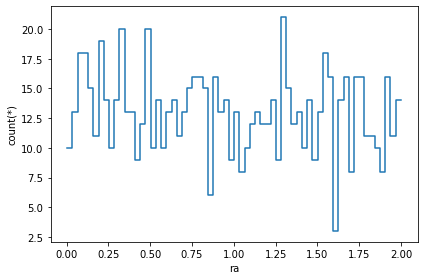

In [80]:
# check the data
tmass = vaex.open_many(glob(join(tmass_data_dir, "*.hdf5")))
tmass.viz.histogram("ra")

In [77]:
tmass

#,ra,dec,jmag,kmag,designation,ph_qual
0,1.026885,-89.175842,11.901,11.433,00040645-8910330,AAA
1,1.076087,-89.012215,16.695,15.64,00041826-8900439,CDD
2,1.112842,-89.039803,15.765,15.183,00042708-8902232,ABC
3,1.119851,-89.91861,12.467,11.963,00042876-8955069,AAA
4,1.126831,-89.655006,16.695,15.314,00043043-8939180,CDU
...,...,...,...,...,...,...
828,0.96741,-88.64447,14.898,14.432,00035217-8838400,AAA
829,0.970521,-88.709099,16.314,14.861,00035292-8842327,BBB
830,0.975295,-88.220215,15.019,14.441,00035407-8813127,AAA
831,0.978394,-88.385124,13.256,12.921,00035481-8823064,AAA


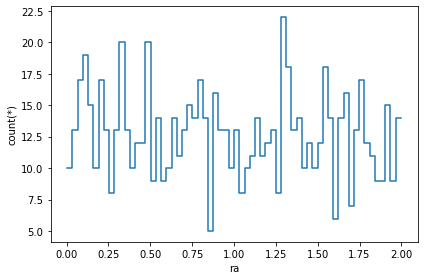

In [81]:
gaia = vaex.open_many(glob(join(gaia_data_dir, "*.hdf5")))
gaia.viz.histogram("ra")

In [82]:
gaia

#,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,glon,glat,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs,ra,dec,jmag,kmag,ph_qual
0,6341071024116923392,27.181486,26.219907673498525,0.1619937,7.165867662690853,0.15926693,0.8462159280166782,0.12653747,18.468872,19.508224,17.452581,25.009687,77.59609,0.98283386,1.3517543,nan,nan,302.9676499367185,-27.26768267853092,3799.133,3732.1882,3952.4932,4.3191,4.2565,4.3851,-0.6771,-0.779,-0.3774,1328.1719,1110.3856,1523.1396,0.5527,0.454,0.6938,nan,nan,nan,nan,nan,nan,nan,nan,nan,,nan,nan,nan,nan,--
1,4611690760072888960,6.8924713,-6.16283580475118,0.43619978,3.0863599386693785,0.40768367,1.1372669643805726,0.34071845,19.688269,20.921812,18.517662,7.7283173,34.448048,1.0588416,1.4700757,nan,nan,302.9628286548731,-27.25695019518819,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,,0.783867,-89.868309,16.567,14.901,BUU
2,4611708008660299264,17.08801,15.516851761166475,0.081242345,-7.157333249113848,0.07781357,1.2855724542192457,0.06615926,17.507706,18.50154,16.532976,61.309105,194.06754,0.9743772,1.3233652,nan,nan,303.0014568841523,-27.404831574405826,4000.4795,3970.193,4025.0796,4.6917,4.6815,4.7024,-0.1676,-0.2143,-0.133,624.159,607.684,638.4129,0.513,0.4907,0.5373,nan,nan,nan,nan,nan,nan,nan,nan,nan,K,0.268558,-89.71653,15.169,14.209,AAA
3,4611709181188492928,6.5878043,4.821691903032647,0.034149557,-4.4889254028881815,0.034355145,0.8222923699537003,0.030214705,15.962487,16.491627,15.286262,229.36317,409.8019,0.9597021,1.2301626,nan,nan,303.01551745721014,-27.46239540245029,4887.0454,4839.9053,5161.509,4.1988,4.1877,4.273,-0.6894,-0.7505,-0.4165,1388.719,1307.4613,1527.9545,0.2559,0.2211,0.4355,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,0.34258,-89.657608,14.428,13.751,AAA
4,4611709387346922880,12.490191,12.39432274452295,0.057449825,1.5445518674661234,0.057337705,0.6999401747378959,0.049945816,16.996668,17.514515,16.347021,129.61122,278.62268,1.0217737,1.2158437,nan,nan,303.0176640705403,-27.47153258215086,4913.182,4848.237,4982.7627,4.7116,4.6903,4.7365,-0.9876,-1.0736,-0.8543,1057.1335,1004.3998,1115.8271,0.1751,0.125,0.2253,nan,nan,nan,nan,nan,nan,nan,nan,nan,G,0.363665,-89.648338,15.516,14.838,AAB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,4612886822564461824,61.342426,56.92306878079999,0.1249683,22.861701753408674,0.12232917,6.842426813094137,0.09899294,17.847067,19.903294,16.506058,18.422266,258.6981,1.0231612,1.5566264,nan,nan,303.38300854090386,-29.041089333818462,3127.656,3126.7273,3129.291,4.9635,4.9613,4.966,0.065,0.0563,0.0735,146.8128,145.5035,148.0269,0.7481,0.7366,0.7594,nan,nan,nan,nan,nan,nan,nan,nan,nan,,1.20566,-88.046265,14.502,13.663,AAA
813,4612886861220777088,2.4308429,-1.863307704177515,0.021097505,-1.5611155571106174,0.021909082,0.872861443704937,0.01782017,14.847667,15.243402,14.285301,717.40906,1361.9264,0.9901175,1.210279,nan,nan,303.3603091361332,-29.054622345682514,5427.8994,5405.3057,5450.979,4.296,4.2849,4.3064,-0.3573,-0.3825,-0.3333,1089.6416,1071.1868,1110.5289,0.139,0.1263,0.1508,nan,nan,nan,nan,nan,nan,nan,nan,nan,F,1.860193,-88.036919,13.57,13.184,AAA
814,4612886895580518144,22.915434,22.851253060603284,0.07982483,1.7138654145737418,0.07778088,0.8022813979717222,0.06346507,17.36722,17.984463,16.627222,81.54515,236.02202,0.98161715,1.2429122,nan,nan,303.3861612733324,-29.044489345859354,441

Now, we are ready to query the whole data.

It is better to run the code in dedicated python file instead of jupyter notebook. This way, we can run the code in the background. We can also run the code in parallel.

In [83]:
# divide into 360 RAs, depend on preference
ras = np.arange(0,360+0.1, 1).astype(int)
dra = ras[1] - ras[0]
decs = np.arange(-90,90+0.1,1).astype(int)
ddec = decs[1] - decs[0]

In [11]:
# ra0 for lower boundry and ra1 for upper boundary
# same with dec0 and dec1
for i, (ra0, ra1) in enumerate(zip(ras[:-1], ras[1:])):
    TOP = 5_000_000 # cap maximum rows for each response, so that the response is not exploding
    df_com = [] #initial table
    df_com_tmass = [] #initial tmass table
    time0 = time()
    progressbar(0, info=f"{ra0}-{ra1}")
    j = 0
    skip = False
    trying = 0
    while j < len(decs) -1:
        if trying > 10:
            print("too many tries, raise error")
            raise Exception("too many tries")
        if ~skip:
            t0 = time()
        dec0 = decs[j]
        dec1 = decs[j+1]
        # query gaia data
        # taking wider ra and dec constrains than 2MASS, because of different epoch
        # the contrains are based on https://doi.org/10.1093/mnras/stab3671
        query_gaia = f"""
        SELECT TOP {TOP} {', '.join(columns)}
        FROM gaiadr3.gaia_source AS gdr3
        LEFT JOIN gaiadr3.astrophysical_parameters AS astrophysical ON astrophysical.source_id = gdr3.source_id
        RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS tmass ON tmass.source_id = gdr3.source_id
        RIGHT JOIN gaiadr3.tmass_psc_xsc_join as join_table ON join_table.clean_tmass_psc_xsc_oid = tmass.clean_tmass_psc_xsc_oid
        WHERE gdr3.ra BETWEEN {ra0-dra*0.5} AND {ra1+dra*0.5}
        AND gdr3.dec BETWEEN {dec0-ddec*0.5} AND {dec1+ddec*0.5} 
        AND parallax > 0
        AND parallax_error/parallax < 0.15
        AND bp_rp BETWEEN -3 AND 6
        AND gdr3.phot_g_mean_mag BETWEEN 3 AND 21
        AND phot_bp_mean_flux_error/phot_bp_mean_flux < 0.15
        AND phot_rp_mean_flux_error/phot_rp_mean_flux < 0.15
        AND ruwe < 1.4	
        AND phot_bp_rp_excess_factor > 1 + 0.015*gdr3.bp_rp*gdr3.bp_rp
        AND phot_bp_rp_excess_factor < 1.3 + 0.06*gdr3.bp_rp*gdr3.bp_rp
        """
        job_gaia = timeout(Gaia.launch_job, args=(query_gaia,), timeout_duration=120)
        if job_gaia == None: #if failed, try again
            print("fail to fetch gaia")
            print("length = ", len(df_com))
            skip = True
            trying += 1
            continue
        result_gaia = job_gaia.get_results()
        if(len(result_gaia) == TOP):
            print(f"gaia data is capped, increase TOP | {TOP}")
            TOP *= 2
            skip = True
            continue
        df_pandas = result_gaia.to_pandas()
        df_pandas = df_pandas.drop_duplicates(subset=['tmass'], keep="first")
        df_pandas.rename(columns={'glon': 'GLON', 'glat': 'GLAT'}, inplace=True)
        df_gaia = vaex.from_pandas(df_pandas)
        # query 2MASS data
        query_tmass = f"""
        SELECT TOP {TOP} {", ".join(columns_tmass)} 
        FROM fp_psc
        WHERE ra BETWEEN {ra0} AND {ra1}
        AND dec BETWEEN {dec0} AND {dec1} 
        AND j_m < 13.5
        AND ph_qual LIKE 'A__'
        AND ph_qual LIKE '__A'
        """
        job_tmass = timeout(tap_tmass.launch_job, args=(query_tmass,), timeout_duration=120)
        if job_tmass == None: 
            print("fail to fetch tmass")
            print("length = ", len(df_com))
            skip = True
            trying += 1
            continue
        result_tmass = job_tmass.get_results()
        if(len(result_tmass) == TOP):
            print(f"tmass data is capped, increase TOP | {TOP}")
            TOP *= 2
            skip = True
            continue
        df_tmass = result_tmass.to_pandas()
        df_tmass.columns = columns_tmass_names
        # join
        df_tmass = vaex.from_pandas(df_tmass)
        join_table = df_tmass.join(df_gaia, left_on="designation", right_on="tmass", how="left")
        join_table.drop(["designation", "tmass"], inplace=True)
        if(len(df_com) == 0):
            df_com = join_table
            df_com_tmass = df_tmass
        else:
            df_com = df_com.concat(join_table)
            df_com_tmass = df_com_tmass.concat(df_tmass)
        j += 1
        t1 = time()
        skip = False
        trying = 0
        TOP = np.max([int(len(df_tmass) * 2), 50_000, int(len(df_gaia) * 2)])
        progressbar((j)/(len(decs)-1)*100, info=f"{ra0}-{ra1} | [{dec0}]-[{dec1}] | {round(t1-t0,2)} s | join = {len(join_table)} | tmass = {len(df_tmass)} | gaia = {len(df_gaia)}| TOP = {TOP}")
    time1 = time()  
    df_com.export(join(gaia_data_dir, f"gaia-{ra0:03d}-{ra1:03d}.hdf5"), progress=True)
    df_com_tmass.export(join(tmass_data_dir, f"tmass-{ra0:03d}-{ra1:03d}.hdf5"), progress=True)
    print(f"{len(df_com)} || {round((time1-time0)/60, 2)}m")
    print(f"{i} saved {ra0}-{ra1} || {datetime.now()}")
    break


[                                                  ]0% 0-1
[##                                                ]6% 0-1 | [-90]-[-80] | 15.9 s | join = 388 | tmass = 388 | TOP = 50000
[#####                                             ]11% 0-1 | [-80]-[-70] | 22.37 s | join = 900 | tmass = 900 | TOP = 50000
[########                                          ]17% 0-1 | [-70]-[-60] | 27.57 s | join = 1182 | tmass = 1182 | TOP = 50000
[###########                                       ]22% 0-1 | [-60]-[-50] | 25.0 s | join = 1266 | tmass = 1266 | TOP = 50000
[#############                                     ]28% 0-1 | [-50]-[-40] | 28.14 s | join = 1355 | tmass = 1355 | TOP = 50000
[################                                  ]33% 0-1 | [-40]-[-30] | 28.72 s | join = 1527 | tmass = 1527 | TOP = 50000
[###################                               ]39% 0-1 | [-30]-[-20] | 21.54 s | join = 1590 | tmass = 1590 | TOP = 50000
[######################                            ]44% 0-1

In [14]:
# ra0 for lower boundry and ra1 for upper boundary
# same with dec0 and dec1
ORI_TOP = 50_000_000
for i, (ra0, ra1) in enumerate(zip(ras[:-1], ras[1:])):
    TOP = ORI_TOP # cap maximum rows for each response, so that the response is not exploding
    df_com = [] #initial table
    df_com_tmass = [] #initial tmass table
    time0 = time()
    progressbar(0, info=f"{ra0}-{ra1}")
    j = 0
    skip = False
    trying = 0
    while j < len(decs) -1:
        if trying > 15:
            print("too many tries, raise error")
            raise Exception("too many tries")
        if ~skip:
            t0 = time()
        dec0 = decs[j]
        dec1 = decs[j+1]
        # query gaia data
        # taking wider ra and dec constrains than 2MASS, because of different epoch
        query_gaia = f"""
        SELECT TOP {TOP} {', '.join(columns)}
        FROM gaiadr3.gaia_source AS gdr3
        LEFT JOIN gaiadr3.astrophysical_parameters AS astrophysical ON astrophysical.source_id = gdr3.source_id
        RIGHT JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS tmass ON tmass.source_id = gdr3.source_id
        RIGHT JOIN gaiadr3.tmass_psc_xsc_join as join_table ON join_table.clean_tmass_psc_xsc_oid = tmass.clean_tmass_psc_xsc_oid
        WHERE gdr3.ra BETWEEN {ra0-dra*1} AND {ra1+dra*1}
        AND gdr3.dec BETWEEN {dec0-ddec*1} AND {dec1+ddec*1} 
        """
        job_gaia = timeout(Gaia.launch_job, args=(query_gaia,), timeout_duration=600)
        print("UWU")
        if job_gaia == None: #if failed, try again
            print("fail to fetch gaia")
            print("length = ", len(df_com))
            skip = True
            trying += 1
            continue
        result_gaia = job_gaia.get_results()
        if(len(result_gaia) == TOP):
            print(f"gaia data is capped, increase TOP | {TOP}")
            TOP *= 2
            skip = True
            continue
        df_pandas = result_gaia.to_pandas()
        df_pandas = df_pandas.drop_duplicates(subset=['tmass'], keep="first")
        df_pandas.rename(columns={'glon': 'GLON', 'glat': 'GLAT'}, inplace=True)
        df_gaia = vaex.from_pandas(df_pandas)
        # query 2MASS data
        query_tmass = f"""
        SELECT TOP {TOP} {", ".join(columns_tmass)} 
        FROM fp_psc
        WHERE ra BETWEEN {ra0} AND {ra1}
        AND dec BETWEEN {dec0} AND {dec1} 
        AND j_m < 13.5
        """
        job_tmass = timeout(tap_tmass.launch_job, args=(query_tmass,), timeout_duration=120)
        if job_tmass == None: 
            print("fail to fetch tmass")
            print("length = ", len(df_com))
            skip = True
            trying += 1
            continue
        result_tmass = job_tmass.get_results()
        if(len(result_tmass) == TOP):
            print(f"tmass data is capped, increase TOP | {TOP}")
            TOP *= 2
            skip = True
            continue
        df_tmass = result_tmass.to_pandas()
        df_tmass.columns = columns_tmass_names
        # join
        df_tmass = vaex.from_pandas(df_tmass)
        join_table = df_tmass.join(df_gaia, left_on="designation", right_on="tmass", how="left")
        join_table.drop(["designation", "tmass"], inplace=True)
        if(len(df_com) == 0):
            df_com = join_table
            df_com_tmass = df_tmass
        else:
            df_com = df_com.concat(join_table)
            df_com_tmass = df_com_tmass.concat(df_tmass)
        j += 1
        t1 = time()
        skip = False
        trying = 0
        TOP = np.max([int(len(df_tmass) * 2), ORI_TOP, int(len(df_gaia) * 2)])
        progressbar((j)/(len(decs)-1)*100, info=f"{ra0}-{ra1} | [{dec0}]-[{dec1}] | {round(t1-t0,2)} s | join = {len(join_table)} | tmass = {len(df_tmass)} | gaia = {len(df_gaia)}| TOP = {TOP}")
    time1 = time()  
    df_com.export(join(gaia_data_dir, f"gaia-{ra0:03d}-{ra1:03d}.hdf5"), progress=True)
    df_com_tmass.export(join(tmass_data_dir, f"tmass-{ra0:03d}-{ra1:03d}.hdf5"), progress=True)
    print(f"{len(df_com)} || {round((time1-time0)/60, 2)}m")
    print(f"{i} saved {ra0}-{ra1} || {datetime.now()}")
    break


[                                                  ] 0% 255-256
UWU
[#                                                 ] 3% 255-256 | [-30]-[-29] | 129.7 s | join = 7963 | tmass = 7963 | gaia = 202932| TOP = 50000000


KeyboardInterrupt: 

In [15]:
df_com

#,ra,dec,Jmag,Kmag,ph_qual,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,fb_over_err,fr_over_err,ruwe,excess_factor,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs
0,0.000464,-84.272873,12.869,12.374,AAA,4617686126396602368,3.6212091,-2.123925825256161,0.018093891,2.9329329266790864,0.015576468,1.2414398898080128,0.014017576,14.117249,14.546528,13.5242605,1097.9094,1719.5553,1.011804,1.2151662,20.115417,3.325204,304.44429715164756,-32.70355447144384,5658.605,5653.9224,5668.203,4.2226,4.2043,4.2496,-0.0402,-0.0457,-0.0316,770.2898,746.2748,786.9589,0.2956,0.2926,0.2995,nan,nan,nan,nan,nan,nan,nan,nan,nan,G
1,0.001247,-82.041222,12.825,12.156,AAA,4630918680117199104,1.7595602,-0.8643814806435555,0.022085961,-1.532611183039537,0.02249431,0.05787829500347088,0.018220302,14.542501,15.125132,13.804353,748.2229,1359.1959,1.0981786,1.254802,243.7743,7.210859,305.0842797396042,-34.87090952692804,5361.0396,5358.2354,5364.41,2.2003,2.2,2.2009,-1.3006,-1.3027,-1.299,11844.438,11838.314,11851.41,0.799,0.7968,0.8014,nan,nan,nan,nan,nan,nan,nan,nan,nan,G
2,0.001998,-84.804314,12.523,11.93,AAA,4617598371624860928,17.00417,16.266358206309686,0.015283653,4.954528511167747,0.016042866,0.686194890423576,0.013194535,14.117252,14.645076,13.433549,974.97577,2022.8025,1.0050431,1.2361251,-23.821648,3.2447915,304.29624940743884,-32.18708166475209,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
3,0.002857,-84.718956,11.746,10.877,AAA,4617602769671367936,5.9807105,5.927853781783437,0.014620288,-0.7933771944304462,0.01440706,0.17823265910718195,0.011743693,13.724135,14.456079,12.896074,962.67413,2366.5325,1.1000682,1.272043,131.92238,1.2741442,304.31980747322217,-32.26998931504778,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
4,0.004052,-82.750267,13.333,12.872,AAA,4630074530064792448,11.209091,10.524865569146224,0.019602386,3.856285092898922,0.02012978,1.027615140072866,0.01769279,14.624002,15.035072,14.034426,890.7594,1179.6777,0.9856547,1.2211474,-43.84897,5.5962825,304.8768564308389,-34.1827911363649,6107.482,6101.212,6117.21,4.2386,4.2239,4.2526,-0.8342,-0.8443,-0.8225,911.0151,895.5346,927.2803,0.619,0.6154,0.624,nan,nan,nan,nan,nan,nan,nan,nan,nan,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"2,499",0.995764,-61.164822,13.447,12.679,AAA,4905628808458200832,35.228916,32.904049421000536,0.024540035,-12.58571385047603,0.024466725,2.6240438140165567,0.023590863,15.270068,15.984568,14.45243,456.00812,1121.7408,1.036435,1.2694062,nan,nan,312.89517546174005,-55.03594452086884,4456.8164,4449.856,4470.296,4.6667,4.6624,4.6713,0.3071,0.2708,0.3548,401.7614,399.8343,404.555,0.2997,0.2939,0.3081,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
"2,500",0.995932,-60.366158,11.679,10.749,AAA,4905913753768390272,237.948,131.28845455960143,0.03185758,-198.45048189872955,0.02766468,28.49055973997624,0.02807787,14.892837,16.820797,13.593732,189.0663,556.4315,1.2046098,1.5155118,28.436165,2.244312,313.3474057627129,-55.79141635510841,3030.2434,3029.2935,3032.0671,5.0505,5.0407,5.0525,-0.1082,-0.1147,-0.077,35.2146,35.0966,36.1397,0.0002,0.0,0.0026,nan,nan,nan,nan,nan,nan,nan,nan,nan,M
"2,501",0.99779,-63.871353,13.314,12.743,AAA,4901335078112927872,9.282132,3.1022623093525334,0.019708283,8.748368312069108,0.020035382,2.045443061782102,0.019035911,14.784108,15.29691,14.116489,712.97504,1327.6842,

Approximately 95 mil rows (23 GB)

taking ~ 48 hours

### Preview adn Cleaning

In [6]:
files = glob(join(gaia_data_dir, "*.hdf5"))
files.sort()
len(files)

360

In [16]:
gaia = vaex.open_many(files)
gaia = gaia[gaia.pm.notnan()].extract()
gaia

#,ra,dec,Jmag,Kmag,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs
0,0.000464,-84.272873,12.869,12.374,4617686126396602368,3.6212091,-2.123925825256161,0.018093891,2.9329329266790864,0.015576468,1.2414398898080128,0.014017576,14.117249,14.546528,13.5242605,20.115417,3.325204,304.44429715164756,-32.70355447144384,5658.605,5653.9224,5668.203,4.2226,4.2043,4.2496,-0.0402,-0.0457,-0.0316,770.2898,746.2748,786.9589,0.2956,0.2926,0.2995,nan,nan,nan,nan,nan,nan,nan,nan,nan,G
1,0.001998,-84.804314,12.523,11.93,4617598371624860928,17.00417,16.266358206309686,0.015283653,4.954528511167747,0.016042866,0.686194890423576,0.013194535,14.117252,14.645076,13.433549,-23.821648,3.2447915,304.29624940743884,-32.18708166475209,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
2,0.002857,-84.718956,11.746,10.877,4617602769671367936,5.9807105,5.927853781783437,0.014620288,-0.7933771944304462,0.01440706,0.17823265910718195,0.011743693,13.724135,14.456079,12.896074,131.92238,1.2741442,304.31980747322217,-32.26998931504778,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
3,0.004052,-82.750267,13.333,12.872,4630074530064792448,11.209091,10.524865569146224,0.019602386,3.856285092898922,0.02012978,1.027615140072866,0.01769279,14.624002,15.035072,14.034426,-43.84897,5.5962825,304.8768564308389,-34.1827911363649,6107.482,6101.212,6117.21,4.2386,4.2239,4.2526,-0.8342,-0.8443,-0.8225,911.0151,895.5346,927.2803,0.619,0.6154,0.624,nan,nan,nan,nan,nan,nan,nan,nan,nan,G
4,0.007844,-82.031616,12.605,12.209,4630918748836674432,18.801056,18.300275763425613,0.016882967,-4.310403819421376,0.018285993,1.1269417803187838,0.013919161,13.798758,14.187072,13.238532,-27.08683,4.7260613,305.0858976745071,-34.88045519689782,5503.932,5470.177,5528.491,4.1392,4.1308,4.148,-0.7153,-0.7508,-0.6893,856.8555,845.9437,867.5156,0.1912,0.1723,0.2052,nan,nan,nan,nan,nan,nan,nan,nan,nan,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"27,001,405",359.991162,81.723877,11.903,11.228,2286403269975358080,5.2602525,5.127952329131903,0.016783616,-1.172331463561274,0.016823703,0.45434838996692956,0.014370571,13.8628235,14.56874,13.046526,-14.39366,2.213932,120.98842984113523,19.046996592015013,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
"27,001,406",359.992311,86.652588,13.491,13.03,2301267842548323584,9.127414,8.573259109347845,0.023041524,3.1319166932358895,0.024572177,1.3792355955819116,0.021768766,14.949071,15.4501915,14.290141,nan,nan,122.11727494824203,23.862584460651433,5192.0254,5167.729,5216.4297,4.4538,4.4444,4.4631,-0.2157,-0.2348,-0.1937,711.6166,700.939,723.2191,0.2872,0.2746,0.2996,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
"27,001,407",359.992988,81.013268,9.471,8.67,2283307320109693312,4.6164536,-4.616426557011018,0.019822646,-0.015870456188812835,0.020180052,1.0655880137082043,0.016312053,11.427629,12.153831,10.600687,-54.240005,0.26263505,120.83167313285159,18.352152471500148,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.05,-0.07,-0.01,-0.07,-0.08,-0.06,-0.09,-0.19,-0.02,K
"27,001,408",359.99454,86.22448,13.406,13.128,2301053231623032064,5.500912,-5.448609975674909,0.018498827,-0.7567577462820062,0.016916338,0.7946582215573009,0.014681197,14.476669,14.788514,13.9952135,-44.64216,8.348065,122.01626514394927,23.

In [18]:
for file in files:
    df = vaex.open(file)
    df_ = df[df.pm.notnan()].extract()
    name = file.split("/")[-1]
    df_.export(join(gaia_data_dir, name), progress=True)
    print(name)

export(hdf5) [########################################] 100.00% elapsed time  :     0.28s =  0.0m =  0.0h
 gaia-000-001.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     0.32s =  0.0m =  0.0h
 gaia-001-002.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     0.36s =  0.0m =  0.0h 
 gaia-002-003.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     0.32s =  0.0m =  0.0h
 gaia-003-004.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     0.32s =  0.0m =  0.0h
 gaia-004-005.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     0.31s =  0.0m =  0.0h
 gaia-005-006.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     0.33s =  0.0m =  0.0h 
 gaia-006-007.hdf5
export(hdf5) [########################################] 100.00% elapsed time  :     0.32s =  0.0m =  0.0h
 gaia-007-008.hdf

In [21]:
files = glob(join(gaia_data_dir,  "*.hdf5"))
files.sort()
len(files)

360

In [22]:
gaia = vaex.open_many(files)
gaia

#,ra,dec,Jmag,Kmag,source_id,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,gmag,bpmag,rpmag,rv_gaia,e_rv_gaia,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs
0,0.000464,-84.272873,12.869,12.374,4617686126396602368,3.6212091,-2.123925825256161,0.018093891,2.9329329266790864,0.015576468,1.2414398898080128,0.014017576,14.117249,14.546528,13.5242605,20.115417,3.325204,304.44429715164756,-32.70355447144384,5658.605,5653.9224,5668.203,4.2226,4.2043,4.2496,-0.0402,-0.0457,-0.0316,770.2898,746.2748,786.9589,0.2956,0.2926,0.2995,nan,nan,nan,nan,nan,nan,nan,nan,nan,G
1,0.001998,-84.804314,12.523,11.93,4617598371624860928,17.00417,16.266358206309686,0.015283653,4.954528511167747,0.016042866,0.686194890423576,0.013194535,14.117252,14.645076,13.433549,-23.821648,3.2447915,304.29624940743884,-32.18708166475209,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
2,0.002857,-84.718956,11.746,10.877,4617602769671367936,5.9807105,5.927853781783437,0.014620288,-0.7933771944304462,0.01440706,0.17823265910718195,0.011743693,13.724135,14.456079,12.896074,131.92238,1.2741442,304.31980747322217,-32.26998931504778,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
3,0.004052,-82.750267,13.333,12.872,4630074530064792448,11.209091,10.524865569146224,0.019602386,3.856285092898922,0.02012978,1.027615140072866,0.01769279,14.624002,15.035072,14.034426,-43.84897,5.5962825,304.8768564308389,-34.1827911363649,6107.482,6101.212,6117.21,4.2386,4.2239,4.2526,-0.8342,-0.8443,-0.8225,911.0151,895.5346,927.2803,0.619,0.6154,0.624,nan,nan,nan,nan,nan,nan,nan,nan,nan,G
4,0.007844,-82.031616,12.605,12.209,4630918748836674432,18.801056,18.300275763425613,0.016882967,-4.310403819421376,0.018285993,1.1269417803187838,0.013919161,13.798758,14.187072,13.238532,-27.08683,4.7260613,305.0858976745071,-34.88045519689782,5503.932,5470.177,5528.491,4.1392,4.1308,4.148,-0.7153,-0.7508,-0.6893,856.8555,845.9437,867.5156,0.1912,0.1723,0.2052,nan,nan,nan,nan,nan,nan,nan,nan,nan,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"27,001,405",359.991162,81.723877,11.903,11.228,2286403269975358080,5.2602525,5.127952329131903,0.016783616,-1.172331463561274,0.016823703,0.45434838996692956,0.014370571,13.8628235,14.56874,13.046526,-14.39366,2.213932,120.98842984113523,19.046996592015013,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
"27,001,406",359.992311,86.652588,13.491,13.03,2301267842548323584,9.127414,8.573259109347845,0.023041524,3.1319166932358895,0.024572177,1.3792355955819116,0.021768766,14.949071,15.4501915,14.290141,nan,nan,122.11727494824203,23.862584460651433,5192.0254,5167.729,5216.4297,4.4538,4.4444,4.4631,-0.2157,-0.2348,-0.1937,711.6166,700.939,723.2191,0.2872,0.2746,0.2996,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
"27,001,407",359.992988,81.013268,9.471,8.67,2283307320109693312,4.6164536,-4.616426557011018,0.019822646,-0.015870456188812835,0.020180052,1.0655880137082043,0.016312053,11.427629,12.153831,10.600687,-54.240005,0.26263505,120.83167313285159,18.352152471500148,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.05,-0.07,-0.01,-0.07,-0.08,-0.06,-0.09,-0.19,-0.02,K
"27,001,408",359.99454,86.22448,13.406,13.128,2301053231623032064,5.500912,-5.448609975674909,0.018498827,-0.7567577462820062,0.016916338,0.7946582215573009,0.014681197,14.476669,14.788514,13.9952135,-44.64216,8.348065,122.01626514394927,23.

# 2MASS

In [23]:
files = glob(join(tmass_data_dir, "*.hdf5"))
files.sort()
len(files)

360

In [24]:
tmass = vaex.open_many(files)
tmass

#,ra,dec,Jmag,Kmag,designation
0,0.000464,-84.272873,12.869,12.374,00000011-8416223
1,0.001247,-82.041222,12.825,12.156,00000029-8202283
2,0.001998,-84.804314,12.523,11.93,00000047-8448155
3,0.002857,-84.718956,11.746,10.877,00000068-8443082
4,0.004052,-82.750267,13.333,12.872,00000097-8245009
...,...,...,...,...,...
"50,234,210",359.992232,81.593384,12.276,11.887,23595813+8135361
"50,234,211",359.992311,86.652588,13.491,13.03,23595815+8639093
"50,234,212",359.992988,81.013268,9.471,8.67,23595831+8100477
"50,234,213",359.99454,86.22448,13.406,13.128,23595868+8613281
